In [15]:
import pathlib
import datetime

# data
import netCDF4
import pandas
import numpy as np

# plots
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean.cm
import cartopy.crs as ccrs


# stats
import statsmodels.stats.outliers_influence
import statsmodels.sandbox.regression.predstd
import statsmodels.graphics.regressionplots
import statsmodels.regression
import statsmodels.tsa.seasonal

# interaction
import tqdm
from IPython.display import YouTubeVideo, display

%matplotlib inline


# Satellite info

This notebook analyses the merged dataset created from the monthly sea-level anomalies from [AVISO](https://www.aviso.altimetry.fr/en/data/products/sea-surface-height-products/global/msla-mean-climatology.html). The data are available from January 1993 and often lag a few months because they are based on the delayed time products. The dataset analysed here are the monthly averaged mean sea-level anomalies. These are derived from the weekly maps of delayed-time sea level anomalies averaging month by month. The data is merged into one file by the process described in the `data/sat` folder. 



In [3]:
# this opens the netCDF file. 
path = pathlib.Path('../../../data/sat/dt_global_merged_msla_h_merged_nc4.nc')
ds = netCDF4.Dataset(str(path))
# and reads all the relevant variable
# Sea-level anomaly
sla = ds.variables['sla'][:]
# time 
time = netCDF4.num2date(ds.variables['time'][:], ds.variables['time'].units)
# location
lon = ds.variables['lon'][:]
lat = ds.variables['lat'][:]

# compute days, seconds * (hours/second)  * (days / hour) -> days
days = np.array([t.timestamp() * 1/3600.0 * 1/24.0 for t in time]) 
# compute relative to first measurement
days = days - datetime.datetime(1970, 1, 1, 0, 0).timestamp()
years = days/365.25


# Sea-level variation
The following animation shows the large variation in monthly sea levels over the last 24 years. This dataset consists of a combination of different missions (Topex-Poseidon, Jason 1,2,3). A detailed description and analysis of this dataset was published by <a href="https://www.nature.com/articles/nclimate2159">Cazenave et al 2013</a>. They show that the most significant variations in the interannual variability are caused by El Niño–Southern Oscillation (e.g. El Niño in 1998 and La Niña in 2011). The movie is generated using the code below. 



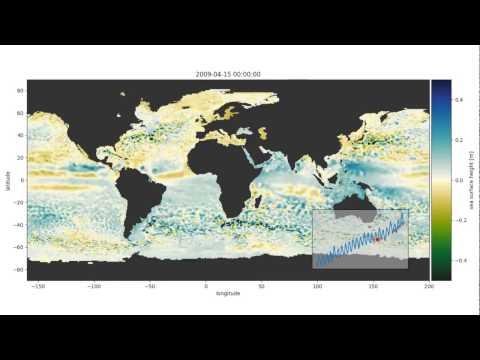

In [4]:
YouTubeVideo('XU0CZlbr4yY')

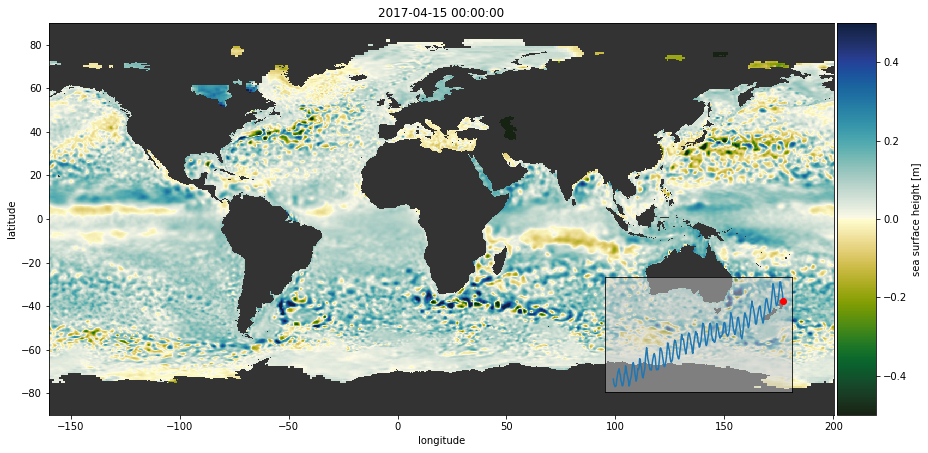

In [5]:
fig, ax = plt.subplots(figsize=(13, 8))
# plot on a dark background
ax.set_facecolor((0.2, 0.2, 0.2))
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
# split up by longitude=200 and merge back
sl = np.ma.hstack([sla[0,:,800:], sla[0,:,:800]])
# show the sea-level anamolies
im = ax.imshow(sl, cmap=cmocean.cm.delta_r, origin='top', vmin=-0.5, vmax=0.5, extent=(lon[800] - 360, lon[800], lat[0], lat[-1]))
# room for a colormap
divider = make_axes_locatable(ax)
# append the colormap axis
cax = divider.append_axes("right", size="5%", pad=0.05)
# show the colormap
plt.colorbar(im, cax=cax, label='sea surface height [m]')
# squeeze toegether
fig.tight_layout()
# inlay for timeseries, transparent background
ax_in = plt.axes([0.65, 0.2, .2, .2], facecolor=(0.8, 0.8, 0.8, 0.5))
series = np.mean(sla, (1, 2))
# plot the line
ax_in.plot(time, series)
ax_in.xaxis.set_visible(False)
ax_in.yaxis.set_visible(False)
# add the moving dot
dot, = ax_in.plot(time[0], series[0], 'ro')

# export to movie
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(
    title='{} {}'.format(ds.variables['sla'].long_name, ds.variables['sla'].units), 
    artist='Fedor Baart',
    comment='Sea-level rise over the period 1993-2017'
)
writer = FFMpegWriter(fps=15, metadata=metadata)
with writer.saving(fig, "avisosla.mp4", 100):
    for i in range(time.shape[0]):
        # update the data and title
        ax.set_title(time[i])
        sl = np.ma.hstack([sla[i,:,800:], sla[i,:,:800]])
        im.set_data(sl)
        dot.set_data(time[i], series[i])
        # snapshot
        writer.grab_frame()


# Global sea-level rise rate
To analyse the global sea-level rise we just average all the measured grid cells and compute a simple regression. 
The first question is which model to use. We choose between a quadratic (accelerating) and linear (constant sea-level rise) model. The linear model is preferred if the quadratic model is not significantly better (based on p-value) and of better quality (based on AIC). The current sea-level rate can be found under the column "coef" in the tables belows. For the quadratic model the current rate can be computed as the current year (for example 2017) minus 1970 times the acceleration plus the current rate. If the current rate is 0.17cm/year and the acceleration is 0.0013cm/year^2, then the current sea-level rise is 0.23cm/year or 23cm per century. In 2017 the sea-level rise rate was considered linear and the sea-level rise is 29cm/century. In literature sometimes corrections are applied to this 29cm, for example for Global Isostatic adjustment, influence of El Niño or by filtering the signal before computing the trend. 

In [6]:
# mean sealevel in m -> cm
mean_sla = np.mean(sla, axis=(1, 2)) * 100.0

# convert times to year
# create a linear model sla ~ constant + time
exog_linear = statsmodels.regression.linear_model.add_constant(years)
# create a quadratic model sla ~ constant + time + time^2
exog_quadratic = statsmodels.regression.linear_model.add_constant(np.c_[years, years**2])

linear_model = statsmodels.regression.linear_model.OLS(mean_sla, exog=exog_linear)
linear_fit = linear_model.fit()
quadratic_model = statsmodels.regression.linear_model.OLS(mean_sla, exog=exog_quadratic)
quadratic_fit = quadratic_model.fit()



if (linear_fit.aic < quadratic_fit.aic):
    print('The linear model is a higher quality model (smaller AIC) than the quadratic model.')
else:
    print('The quadratic model is a higher quality model (smaller AIC) than the linear model.')
if (quadratic_fit.pvalues[2] < 0.05):
    print('The quadratic term is bigger than we would have expected under the assumption that there was no quadraticness.')
else:
    print('Under the assumption that there is no quadraticness, we would have expected a quadratic term as big as we have seen.')
    
# choose the model, prefer the most parsimonuous when in doubt.
if  (linear_fit.aic < quadratic_fit.aic) or quadratic_fit.pvalues[2] >= 0.05:
    display(quadratic_fit.summary(title='Quadratic model (not used)'));    
    display(linear_fit.summary(title='Linear model (used)'))
    print('The linear model is preferred as the quadratic model is not both significant and of higher quality.')
    fit = linear_fit
    model = linear_model
else:
    display(linear_fit.summary(title='Linear model (not used)'))
    display(quadratic_fit.summary(title='Quadratic model (used)'));    
    print('The quadratic model is preferred as it is both significantly better and of higher quality.')
    fit = quadratic_fit
    model = quadratic_model

The quadratic model is a higher quality model (smaller AIC) than the linear model.
Under the assumption that there is no quadraticness, we would have expected a quadratic term as big as we have seen.


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Quadratic model (not used)                          
==============================================================================
Dep. Variable:                      y   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     1463.
Date:                Tue, 26 Jun 2018   Prob (F-statistic):          6.35e-152
Time:                        15:08:51   Log-Likelihood:                -290.66
No. Observations:                 292   AIC:                             587.3
Df Residuals:                     289   BIC:                             598.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.4599      1.743     -4.279      0.000     -10.891      -4.028
x1             0.1765      0.079      2.240      0.026       0.021       0.331
x2             0.0013      0.001      1.528      0.128      -0.000       0.003
==============================================================================
Omnibus:                       13.624   Durbin-Watson:                   0.281
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                7.406
Skew:                           0.199   Prob(JB):                       0.0246
Kurtosis:                       2.329   Cond. No.                     9.84e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                             Linear model (used)                              
==============================================================================
Dep. Variable:                      y   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     2911.
Date:                Tue, 26 Jun 2018   Prob (F-statistic):          3.00e-153
Time:                        15:08:51   Log-Likelihood:                -291.84
No. Observations:                 292   AIC:                             587.7
Df Residuals:                     290   BIC:                             595.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.0958      0.250    -40.321      0.000     -10.589      -9.603
x1             0.2965      0.005     53.952      0.000       0.286       0.307
==============================================================================
Omnibus:                       11.153   Durbin-Watson:                   0.279
Prob(Omnibus):                  0.004   Jarque-Bera (JB):                6.779
Skew:                           0.209   Prob(JB):                       0.0337
Kurtosis:                       2.382   Cond. No.                         296.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The linear model is preferred as the quadratic model is not both significant and of higher quality.


# Global sea-level rise
The figure below shows the recent sea-level rise with the fitted trend based on the model above. 

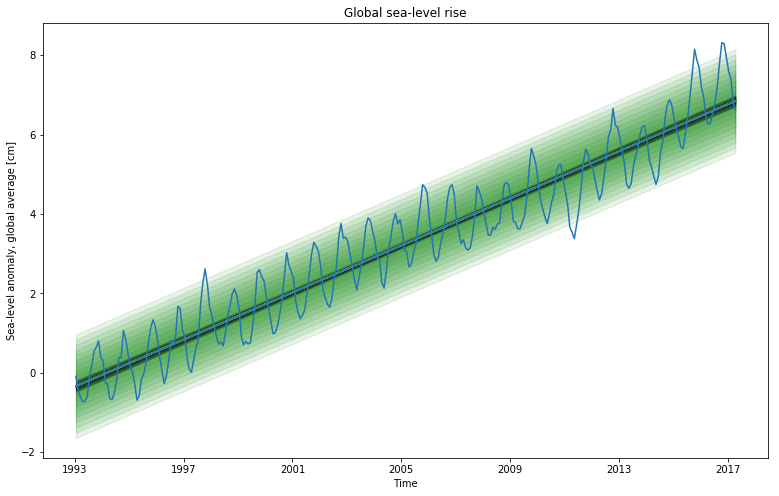

In [7]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.set_title('Global sea-level rise')
ax.plot(time, mean_sla)
ax.set_xlabel('Time')
ax.set_ylabel('Sea-level anomaly, global average [cm]')


# add the prediction interval
prstd, iv_l, iv_u = statsmodels.sandbox.regression.predstd.wls_prediction_std(fit)
# plot the prediction itnervals
for i in np.linspace(0.1, 1.0, num=10):
    ax.fill_between(
        time, 
        (iv_l - fit.fittedvalues)*i + fit.fittedvalues, 
        (iv_u - fit.fittedvalues)*i + fit.fittedvalues, 
        alpha=0.1,
        color='green'
    )
# get the confidence interval for the fitted line  from the outlier table
table = statsmodels.stats.outliers_influence.summary_table(fit)
st, data, ss2 = table
predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T

# plot the confidence intervals
for i in np.linspace(0.1, 1.0, num=10):
    ax.fill_between(
        time, 
        (predict_mean_ci_low - fit.fittedvalues)*i + fit.fittedvalues, 
        (predict_mean_ci_upp - fit.fittedvalues)*i + fit.fittedvalues, 
        alpha=0.1,
        color='black'
    )
    ax.plot(time, fit.fittedvalues);



Because the global sea-level trend shows such a strong seasonal signal, one could consider to decompose the signal into different parts, a trend, seasonal pattern and the remainder. This is done using a standard time decomposition algorithm.  

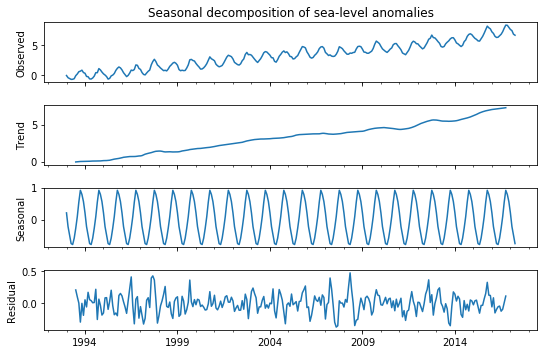

In [8]:
index = pandas.date_range(time[0], periods=len(time), freq='M')
df = pandas.DataFrame(index=index, data=dict(ssh=mean_sla))
model = statsmodels.tsa.seasonal.seasonal_decompose(df.ssh)

fig = model.plot()
fig.set_size_inches(8, 5)
fig.axes[0].set_title('Seasonal decomposition of sea-level anomalies');

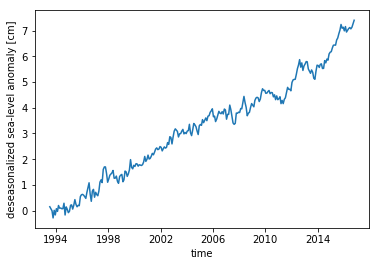

In [9]:
# this allows us to create a trend without the seasonal effect
fig, ax = plt.subplots()
ax.plot(time, model.trend + model.resid)
ax.set_xlabel('time')
ax.set_ylabel('deseasonalized sea-level anomaly [cm]');

# Gravitation
Using the Grace satellites it is possible to detect changes in gravity (e.g. [Wouters 2011](http://onlinelibrary.wiley.com/doi/10.1029/2010GL046128)) and we had models that showed how self-gravitation contributes to differences in regional sea-level rise (e.g. [Slangen 2014](http://dx.doi.org/10.1007/s10584-014-1080-9)). Recently the first measured gravitational fingerprints were computed [Hsu 2017](http://dx.doi.org/10.1002/2017GL074070. One expects to find different sea-level rise rates as a function of latitude. 
That is something that we compute in this analysis. 

The figure below shows the sea-level variation, averaged over latitude as a function of time. One can sea the phase shift of seasonal patterns around the equator and by the sea-level rise by the more blueish colors on the right. 

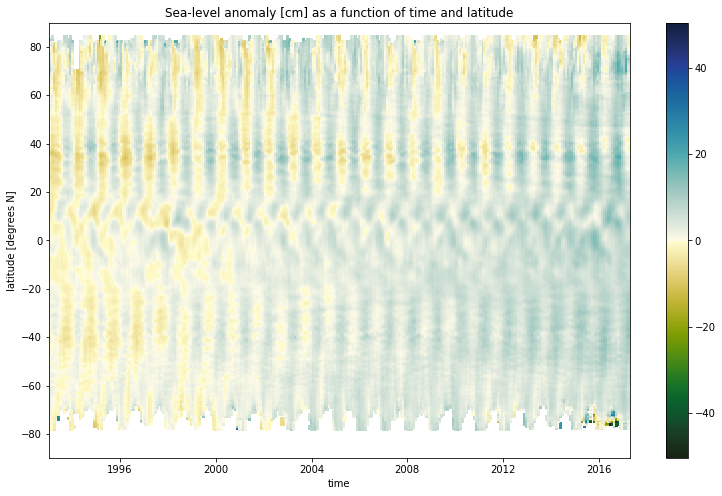

In [10]:
fig, ax = plt.subplots(figsize=(13,8))
# mean, m -> cm
mean_lat_sla = sla.mean(axis=2) * 100

# make sure we use a symetric range, because we're using a divergent colorscale
vmax = np.abs(mean_lat_sla).max()
pc = ax.pcolor(time, lat, mean_lat_sla.T, cmap=cmocean.cm.delta_r, vmin=-vmax, vmax=vmax)
ax.set_xlabel('time')
ax.set_ylabel('latitude [degrees N]')
ax.set_title('Sea-level anomaly [cm] as a function of time and latitude')
plt.colorbar(pc, ax=ax);

In [11]:
def fit(years, sla):
    # no const (fit through 0)
    exog = statsmodels.regression.linear_model.add_constant(years)
    linear_model = statsmodels.regression.linear_model.OLS(sla, exog)
    fit = linear_model.fit()
    const, trend = fit.params
    # cm/year * 100/1 year/century) -> cm / century
    return trend * 100

def make_latitude_plot(years, lat, mean_lat_sla):
    # compute trend per latitude
    trends = np.array([fit(years, series) for series in mean_lat_sla.T])

    # create a figure for zoomed out and zoomed in plot
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    # global trend
    ax = axes[0]
    ax.plot(trends, lat, alpha=0.4)
    ax.set_ylim(-80, 80)
    ax.set_xlim(0, 40)
    ax.set_xlabel('slr [cm/century]')
    ax.set_ylabel('latitude [degrees]')

    # pick a location in NL
    (idx,) = np.nonzero(lat == 52.125)
    ax.plot(trends[idx], 52.125, 'r+')
    text = "Scheveningen: %.1f" % (trends[idx], )
    ax.annotate(text, (trends[idx], 53.125))
    ax.set_title('Sea-level rise [1993-2016] averaged per latitude');

    # same plot, zoomed in to NL
    ax = axes[1]
    ax.plot(trends, lat, alpha=0.4, label='sea-level rise [cm/century]')
    ax.set_ylim(51, 54)
    ax.set_xlim(10, 30)
    ax.set_xlabel('slr [cm/century]')
    ax.set_ylabel('latitude [degrees]')
    ax.set_title('Sea-level rise [1993-2016] averaged per latitude')
    ax.legend(loc='best')
    locations = [
        (53.375, 'Schiermonnikoog'),
        (52.625, 'Egmond aan Zee'),
        (51.375, 'Vlissingen')
    ]    
    for lat_i, label in locations: 
        (idx,) = np.nonzero(lat == lat_i)
        ax.plot(trends[idx], lat_i, 'r+')
        text = "%s: %.1f" % (label, trends[idx])
        ax.annotate(text, (trends[idx], lat_i))  
    return fig, ax

Based on the theory of self gravitation and the fingerprints one would expect to see a lower sea-level rise at more extreme altitudes. 
This is clearly visible at the latitudes near Antarctica, where sea-level rise is almost absent. The sea-level rise is highest around 30 degrees North and 40 degress south. 
The sea-level rise at the Netherlands is low, around 20 cm/century, and shows an even lower rate around latitudes at the height of the Wadden. 

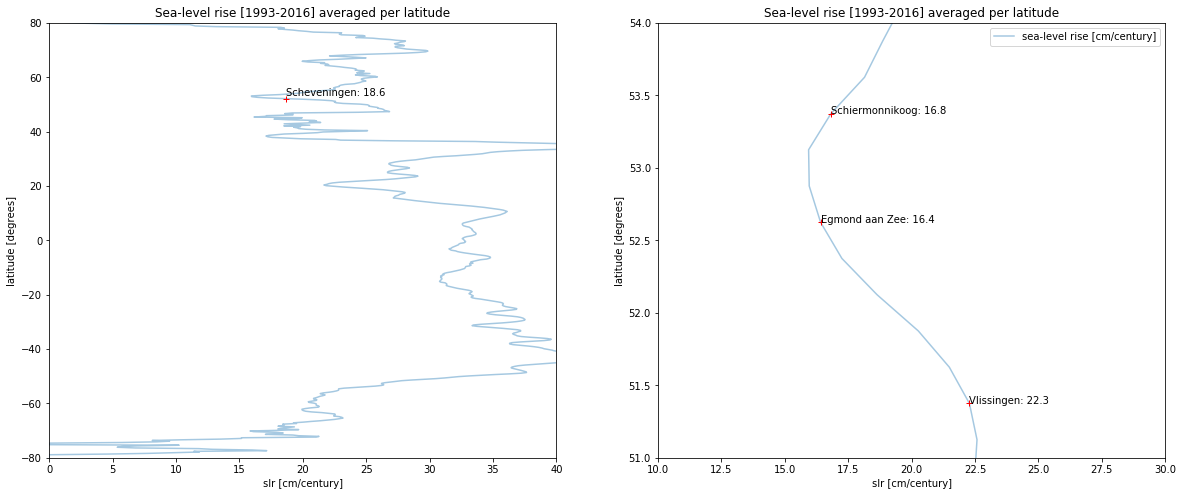

In [12]:
fig, ax = make_latitude_plot(years, lat, mean_lat_sla)


In [13]:
trends = np.ma.masked_all_like(sla[0, ...])
for i, j in tqdm.tqdm_notebook(np.ndindex(sla.shape[1:]), total=sla.shape[1]*sla.shape[2]):
    trends[i, j] = fit(years=years, sla=sla[:, i, j])


HBox(children=(IntProgress(value=0, max=1036800), HTML(value='')))

Text(0,0.5,'Latitude')

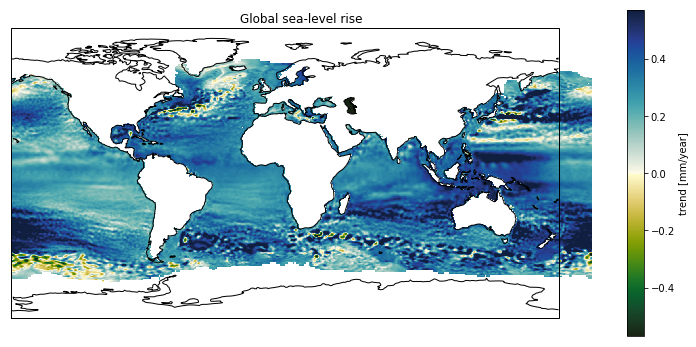

In [28]:
fig, ax = plt.subplots(figsize=(13, 6), subplot_kw=dict(projection=ccrs.PlateCarree()))
# plot on a dark background
ax.coastlines()
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
# split up by longitude=200 and merge back
trends_ma = np.ma.masked_array(trends, mask=sla.mask.sum(axis=0) > 0)
trends_rotated = np.ma.hstack([trends_ma[:,800:], trends_ma[:,:800]])
# show the sea-level anamolies
p95 = np.percentile(np.abs(trends_ma[~trends_ma.mask]), 95)
im = ax.imshow(
    trends_rotated, 
    cmap=cmocean.cm.delta_r, 
    vmin=-p95, 
    vmax=p95, 
    transform=ccrs.PlateCarree(), 
    extent=(
        lon[800] - 360, 
        lon[800], 
        lat[0], 
        lat[-1]
    ), 
    origin='top'
)
ax.set_title('Global sea-level rise')

cb = plt.colorbar(im, ax=ax)
cb.set_label('trend [mm/year]')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Sea-level trends
Using the seasonal decomposition and the analysis per latitude one can compute the sea-level trends per latitude over time.  This shows a checkerboard like pattern at the equator and lower sea-level rise at the more extreme latitudes

In [12]:
index = pandas.date_range(time[0], periods=len(time), freq='M')

def decompose(series):
    df = pandas.DataFrame(index=index, data=dict(ssh=series))
    model = statsmodels.tsa.seasonal.seasonal_decompose(df.ssh)
    return model.trend 
decompositions = []
for series in mean_lat_sla[:, 90:-90].T:
    decomposed = decompose(series)
    decompositions.append(np.array(decomposed))
    
    
    


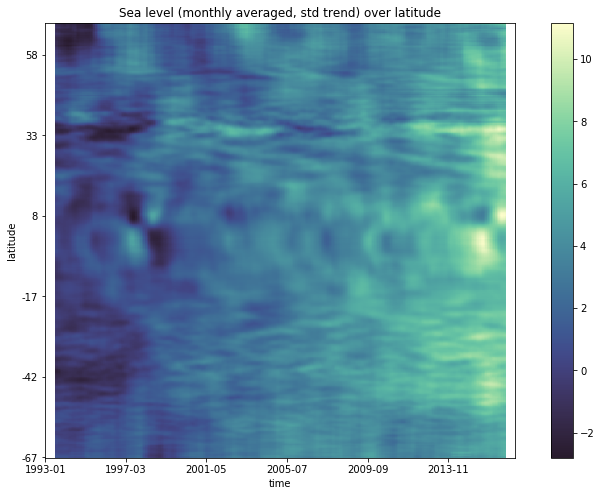

In [13]:
import matplotlib.cm
fig, ax = plt.subplots(figsize=(13, 8))
vmax = np.vstack(decompositions).max()

im = ax.imshow(np.vstack(decompositions), aspect=0.5, cmap=cmocean.cm.deep_r, origin='top') 

xlabels = [
    time[loc].strftime('%Y-%m') if (loc >= 0 and loc < 300) else '' 
    for loc 
    in ax.xaxis.get_ticklocs().astype('int')
]
_ = ax.xaxis.set_ticklabels(xlabels)
ylabels = [
    "%.0f" % (lat[90:-90][loc], ) if loc < 540 else ''
    for loc 
    in ax.yaxis.get_ticklocs().astype('int')
]
y = ax.yaxis.set_ticklabels(ylabels)

ax.set_title('Sea level (monthly averaged, std trend) over latitude')
ax.set_xlabel('time')
ax.set_ylabel('latitude')
plt.colorbar(im, ax=ax);